## Формирование решения

In [7]:
# подгружаем все нужные пакеты
import pandas as pd
import numpy as np


# для встроенных картинок
%pylab inline
# чуть покрасивше картинки:
pd.set_option('display.mpl_style', 'default')
figsize(15, 10)

import warnings
warnings.filterwarnings("ignore")

#plt.rcParams['figure.figsize'] = 10, 7.5
#plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Ubuntu'

Populating the interactive namespace from numpy and matplotlib


## Формирование признаков

In [8]:
from sklearn.preprocessing import LabelEncoder

def replace_1(x):
    if x not in ['Graduate', 'Class XII', 'Class X',
                 'Masters of Business Administration', 'Others', nan]:
        return 'something'
    return (x)


def makematrix(train_d):
    train_d['weekday'] = pd.to_datetime(train_d.Application_Receipt_Date).dt.dayofweek
    train_d['month'] = pd.to_datetime(train_d.Application_Receipt_Date).dt.month
    train_d['day'] = pd.to_datetime(train_d.Application_Receipt_Date).dt.day

    train_d['weekday2'] = pd.to_datetime(train_d.Manager_DOJ).dt.dayofweek
    train_d['month2'] = pd.to_datetime(train_d.Manager_DOJ).dt.month
    train_d['day2'] = pd.to_datetime(train_d.Manager_DOJ).dt.day
    
    
    
    train_d['Application_Receipt_Date'] = pd.to_datetime(train_d.Application_Receipt_Date)
    train_d['Applicant_BirthDate'] = pd.to_datetime(train_d.Applicant_BirthDate)
    train_d['Manager_DOJ'] = pd.to_datetime(train_d.Manager_DOJ)
    train_d['Manager_DoB'] = pd.to_datetime(train_d.Manager_DoB)
    train_d['delta_DOB'] = train_d['Manager_DoB'] - train_d['Applicant_BirthDate']
    train_d['delta_dates'] = train_d['Manager_DoB'] - train_d['Manager_DOJ']
    
    train_d['Applicant_BirthDate'] = (train_d.Applicant_BirthDate - pd.Timestamp('1930-02-28 00:00:00')).dt.total_seconds()
    train_d['Application_Receipt_Date'] = (train_d.Application_Receipt_Date - pd.Timestamp('1930-02-28 00:00:00')).dt.total_seconds()
    train_d['Manager_DoB'] = (train_d.Manager_DoB - pd.Timestamp('1930-02-28 00:00:00')).dt.total_seconds()
    train_d['Manager_DOJ'] = (train_d.Manager_DOJ - pd.Timestamp('1930-02-28 00:00:00')).dt.total_seconds()
    train_d['delta_DOB'] = train_d.delta_DOB.dt.total_seconds()
    train_d['delta_dates'] = train_d.delta_dates.dt.total_seconds()
#     del train_d['Application_Receipt_Date']
#     del train_d['Applicant_BirthDate']
#     del train_d['Manager_DOJ']
#     del train_d['Manager_DoB']


    # leakage
    train_d['num_of_sale'] = np.arange(train_d.shape[0])
    tmp = train_d['Application_Receipt_Date'].map(train_d.groupby('Application_Receipt_Date').num_of_sale.min())
    train_d['sales_in_day'] = train_d['Application_Receipt_Date'].map(train_d.groupby('Application_Receipt_Date').num_of_sale.max()) - tmp + 1
    train_d['num_of_sale'] = train_d['num_of_sale'] - tmp
    train_d['invert_num_of_sale'] = train_d['sales_in_day'] - train_d['num_of_sale'] - 1
    train_d['per_of_sale'] = train_d.num_of_sale/train_d['Application_Receipt_Date'].map(train_d.groupby('Application_Receipt_Date').num_of_sale.max())
    train_d['per_of_sale'] = train_d['per_of_sale'].fillna(0.0)

    
    
    
    train_d['Manager_Joining_Designation'] = train_d['Manager_Joining_Designation'].map({nan:-1, 'Other':0, 'Level 1':1, 'Level 2':2, 'Level 3':3, 'Level 4':4, 'Level 5':5, 'Level 6':6, 'Level 7':7})
    #del train_d['Manager_Joining_Designation']
    # nan <-> other
    train_d['Applicant_Marital_Status'] = train_d['Applicant_Marital_Status'].map({nan:-1, 'S':1, 'M':2, 'W':3, 'D':4})
    
    train_d['Applicant_Qualification'] = train_d['Applicant_Qualification'].apply(replace_1)
    train_d['Applicant_Qualification'] = train_d['Applicant_Qualification'].map({'Graduate':4, 'Class XII':2, 'Class X':1, 'Masters of Business Administration':3, 'something':0, 'Others':5, nan:-1})
    
    train_d['Applicant_Occupation'] = train_d['Applicant_Occupation'].map({nan:0, 'Self Employed':1, 'Business':2, 'Salaried':3, 'Others':4, 'Student':5})
    # nan <-> 'Self Employed'
#     train_d['Applicant_Occupation_0'] = train_d['Applicant_Occupation']==0
#     train_d['Applicant_Occupation_1'] = train_d['Applicant_Occupation']==1
#     train_d['Applicant_Occupation_2'] = train_d['Applicant_Occupation']==2
#     train_d['Applicant_Occupation_3'] = train_d['Applicant_Occupation']==3
#     train_d['Applicant_Occupation_4'] = train_d['Applicant_Occupation']==4
#     train_d['Applicant_Occupation_5'] = train_d['Applicant_Occupation']==5
    
    
    
    train_d['Manager_Current_Designation'] = train_d['Manager_Current_Designation'].map({nan:-1, 'Other':0, 'Level 1':1, 'Level 2':2, 'Level 3':3, 'Level 4':4, 'Level 5':5, 'Level 6':6, 'Level 7':7})
    # 1 2 nan 3 5 4
    
    train_d['eq_Destinations'] = train_d['Manager_Current_Designation']==train_d['Manager_Joining_Designation'] 
    
    train_d['Manager_Status'] = train_d['Manager_Status'].map({'Confirmation':-1, nan:0, 'Probation':1})
    
    #del train_d['Manager_Status'] # не играет роли!!!
    
    # 'Manager_Grade' (nan -> 4.5)
    # Manager_Num_Application - не трогать
    # Manager_Num_Coded
    # Manager_Num_Products
    # Manager_Num_Products2

    train_d['Applicant_Gender'] = train_d['Applicant_Gender'].map({'M':1, 'F':-1, nan:0})
    # nan <-> F!
    train_d['Manager_Gender'] = train_d['Manager_Gender'].map({'M':1, 'F':-1, nan:0})
    train_d['genders'] = train_d['Manager_Gender'].astype(str) + train_d['Applicant_Gender'].astype(str)
    train_d['genders'] = train_d['genders'].map({'11':1, '-11':3, '1-1':4, '-1-1':6, '01':2, '0-1':5, '10':0, '00':0, '-10':0})
    #del train_d['Applicant_Gender']
    #del train_d['Manager_Gender']
    
    train_d['num_products'] =  train_d.Manager_Num_Products + train_d.Manager_Num_Products2
    train_d['num_products2'] =  train_d.Manager_Num_Products - train_d.Manager_Num_Products2
    
    
#     encoder = LabelEncoder()
    
#     for f in ['Office_PIN', 'Applicant_City_PIN','Manager_Business', 'Manager_Business2']:
#         print (f)
#         train_d[f].fillna(-1.1, inplace=True)
#         encoder.fit(train_d[f])
#         train_d[f] = encoder.transform(train_d[f])

#     for f in ['Office_PIN', 'Applicant_City_PIN','Manager_Business', 'Manager_Business2']:
#         print (f)
#         s = train_d.groupby(f)['Applicant_Occupation_3'].mean()
#         train_d[f + '_accup3'] = train_d[f].map(s)
        
        
    for f in ['Office_PIN', 'Applicant_City_PIN','Manager_Business', 'Manager_Business2']: # , 'Applicant_City_PIN','Manager_Business', 'Manager_Business2'
        print (f)
        s = train_d.groupby(f).size()
        train_d[f] = train_d[f].map(s)
        
    train_d.drop(['ID'], axis=1, inplace=True)
    
    #  'Office_PIN', 'Applicant_City_PIN','Manager_Business', 'Manager_Business2'
    
    return (train_d)

## Загрузка данных

In [9]:
train_d = pd.read_csv('Train_pjb2QcD.csv')
test_d = pd.read_csv('Test_wyCirpO.csv')
print (train_d.shape, test_d.shape)

ind = pd.to_datetime(train_d['Application_Receipt_Date'])>pd.Timestamp('2007-12-01')
train_d = train_d[ind]
print (train_d.shape)

data = pd.concat([train_d, test_d])
data = makematrix(data)

m = train_d.shape[0]
y = data.Business_Sourced.values[:m]
data.fillna(-1.1, inplace=True)
train = data[data.columns - ['Business_Sourced']].iloc[:m,:]
test = data[data.columns - ['Business_Sourced']].iloc[m:,:]

(9527, 23) (5045, 22)
(3945, 23)
Office_PIN
Applicant_City_PIN
Manager_Business
Manager_Business2


## GBM

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
#model = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=8, random_state=0, loss='ls')
model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=1, random_state=0, loss='ls')

model.fit(train, y)

a = model.predict(test)

a = (a-min(a))/(max(a)-min(a))

df = pd.DataFrame({'ID':test_d.ID.values, 'Business_Sourced':a})

df[['ID','Business_Sourced']].to_csv('dj_ans10_gbm_allf2_2007-11.csv', index=False)
df[['ID','Business_Sourced']][:3]

,ID,Business_Sourced
0,FIN1009528,0.914380
1,FIN1009529,0.914606
2,FIN1009530,0.826344


In [12]:
arf = a.copy()
arf

array([ 0.91437973,  0.91460588,  0.8263435 , ...,  0.0982681 ,
        0.09497696,  0.11070545])

In [5]:
 1000     0.67713298557 (*)
    
  
0.673494117381
0.652022220717

0.689194499018 (кодировка по мощности)
0.690706591694Manager_Joining_Designation
0.689194499018Applicant_Marital_Status
0.689223855656Applicant_Qualification
0.568623625319Applicant_Occupation
0.689194499018 Manager_Status
0.687910033196 genders
0.6772490572
0.682138518167 new factor
0.658463970372 Office_PIN
0.655596052661 City_PIN
0.649612266558 Manager_Business
0.689194499018 allf
0.689194499018 allf2

    
0.659535713479 -02month
0.602871530836 -03
0.690057584175 07-12
0.677922904952 07-11

0.673494117381

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(max_features=15, n_estimators=5000,  max_depth=3)
model.fit(train, y)
a = model.predict(test)
a = (a-min(a))/(max(a)-min(a))
df = pd.DataFrame({'ID':test_d.ID.values, 'Business_Sourced':a})
df[['ID','Business_Sourced']].to_csv('dj_rf_tmp.csv', index=False)

In [14]:
agbm = a.copy()
agbm

array([ 0.85804784,  0.84684486,  0.80615384, ...,  0.01493235,
        0.01329878,  0.01387397])

In [15]:
0.688187340514
0.68812230427
0.627019849604
0.696580629135 (по мощности кодировка)
0.696219316668 Manager_Joining_Designation
0.695830905765 Applicant_Marital_Status
0.695998916063 Applicant_Qualification
0.55431203848  Applicant_Occupation [важный!]
0.697021430346  Manager_Status
0.696546304451 genders
0.686543368787 plus
0.693352302238 new factor
0.644673576768 OfficePIN
0.648233407854 City_PIN
0.622447440327 Manager_Business
0.696013368561 allf
0.696925682542 (околорекордный)

0.672433213649 -02 month
0.703033669806 - 07-12
0.694923108191 - 07-11


SyntaxError: invalid syntax (<ipython-input-15-4776bcc0ecb9>, line 4)

## Ансамбль

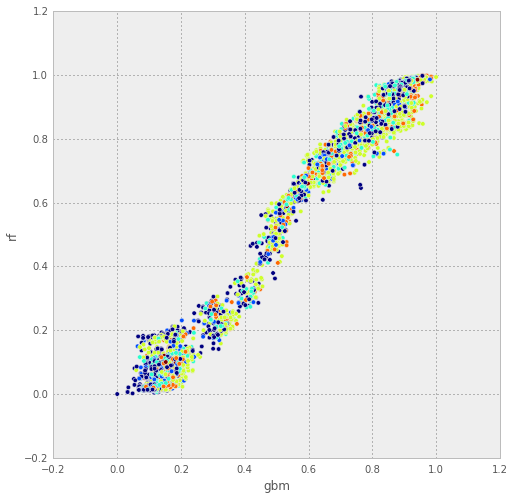

In [25]:
#plt.plot([], figsize = (5,5))
plt.rcParams['figure.figsize'] = 8, 8
plt.scatter(arf, agbm, c=test.Applicant_Occupation.values)
plt.xlabel('gbm')
plt.ylabel('rf')
plt.legend()

In [24]:
alpha = 0.8

a = (1-alpha)*arf + alpha*agbm

df = pd.DataFrame({'ID':test_d.ID.values, 'Business_Sourced':a})
df[['ID','Business_Sourced']].to_csv('dj_ens07.csv', index=False)


In [ ]:
0.9 0.705113023056
0.8 0.705280130072
0.7 0.705077795091

## + ridge

In [93]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import Ridge

model = Ridge(alpha=0.01, normalize=True)

model.fit(train, y)
#a = model.predict_proba(test)[:,1]
a = model.predict(test)
arg = (a-min(a))/(max(a)-min(a))
#df = pd.DataFrame({'ID':test_d.ID.values, 'Business_Sourced':a})
#df[['ID','Business_Sourced']].to_csv('dj_rg2.csv', index=False)

In [ ]:
0.63
0.639944448208
0.642610482578


In [97]:
alpha = 0.8
beta = 0.95

a = beta*((1-alpha)*arf + alpha*agbm) + (1-beta)*arg

df = pd.DataFrame({'ID':test_d.ID.values, 'Business_Sourced':a})
df[['ID','Business_Sourced']].to_csv('dj_ens_095.csv', index=False)
#0.704023665967.